In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import yfinance as yf
import matplotlib.pyplot as plt

#calculate R^2
def slope(ts):
    x = np.arange(len(ts))
    log_ts = np.log(ts)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)
    annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100
    score = annualized_slope * (r_value ** 2)
    return score

In [2]:
#Inverse Volatility Weight portfolio consturction
def inv_vola_calc(ts):
    vola_window = 20
    return ts.pct_change().rolling(vola_window).std().dropna().iloc[-1]

In [3]:
#Setting Params for Momentum
def get_params():
    minimum_momentum = 0  # momentum score cap

    number_of_stocks = 27

    # Most momentum research excludes most recent data.
    exclude_days = 0  # excludes most recent days from momentum calculation
    # 4 OR 5 Fix this

    return minimum_momentum, number_of_stocks, exclude_days

In [4]:
def build_mom_list(momentum_window, tickers_list, total_hist):
    minimum_momentum, number_of_stocks, exclude_days = get_params()
    
    hist = pd.DataFrame(columns=tickers_list)
    
    hist_window = momentum_window + exclude_days
    
    for ticker in tickers_list:
        ticker = str(ticker)
        hist[ticker] = total_hist[ticker]["Close"].tail(hist_window)
        #volume[ticker] = total_hist[ticker]["Volume"].tail(200+2)[:-2]
    
    data_end = -1 * (exclude_days + 1)# exclude most recent data

    hist = hist.dropna()

    momentum1_start = -1 * (momentum_window + exclude_days)
    momentum_hist1 = hist[momentum1_start:data_end]

    momentum_list = momentum_hist1.apply(slope)  # Mom Window 1

    ranking_table = momentum_list.sort_values(ascending=False)

    ranking_table.to_csv("sector_ranking_table.csv")

    buy_list = ranking_table[:number_of_stocks]

    final_buy_list = buy_list[buy_list > minimum_momentum]

    return ranking_table, hist

#print(build_mom_list())

In [5]:
#plt.figure(figsize=(25, 20))
#sns.heatmap(hist.corr(), cmap='Spectral_r', linewidths=1, annot=True, fmt='.2f')
#plt.show()

In [6]:
#plt.figure(figsize=(25, 15))
#sns.heatmap(final_buy_hist.corr(), cmap='Spectral_r', linewidths=1, annot=True, fmt='.2f')
#plt.show()

In [7]:
dfSectors = pd.read_excel(r"C:\Users\samla\PycharmProjects\DeepOcean\Comm_Universe.xlsx", engine='openpyxl')

tickers_list = dfSectors["Symbol"].values.tolist()

total_hist = yf.download(tickers=tickers_list, period="1y",
                        interval="1d", group_by='ticker',
                        auto_adjust=True, prepost=True,
                        threads=True, proxy=None)

[*********************100%***********************]  26 of 26 completed


In [8]:
from pandas.tseries.offsets import BMonthEnd, BusinessDay
from datetime import date

d=date.today()
idx = pd.IndexSlice
year_start = total_hist.loc['2021-12-31',idx[:,'Close']]

offset = BusinessDay(n=0)
curr_bd = (d - offset).strftime('%Y-%m-%d')
current = total_hist.loc[curr_bd,idx[:,'Close']]

ytd_df = pd.merge(year_start,current, right_index = True, left_index = True)
ytd_df['YTD Return %'] = (ytd_df[curr_bd]- ytd_df['2021-12-31']) / ytd_df['2021-12-31']

offset = BMonthEnd()

prev_mtd = offset.rollback(d).strftime('%Y-%m-%d')
prev_mtd_srs = total_hist.loc[prev_mtd,idx[:,'Close']]

mtd_df = pd.merge(prev_mtd_srs,current, right_index = True, left_index = True)
mtd_df['MTD Return %'] = (mtd_df[curr_bd]- mtd_df[prev_mtd]) / mtd_df[prev_mtd]

returns_df = pd.DataFrame(index=mtd_df.index)

returns_df['MTD Return %'],returns_df['YTD Return %'] = mtd_df['MTD Return %'],ytd_df['YTD Return %']

returns_df = returns_df.droplevel(level=1).sort_values(by = 'YTD Return %', ascending = False)

returns_df.to_csv("returns_df_Comm.csv")

In [9]:
dict_cols = {20:'1-Month',
                60:'3-Months',
                125:'6-Months',
                '20-corr':'1-Month Corr',
                '60-corr':'3-Months Corr',
                '125-corr':'6-Months Corr'}

time_list = [20,60,125]
r2_table = pd.DataFrame(columns=time_list, index=tickers_list).sort_index()

for time in time_list:
    ranking_t, hist_for_corr = build_mom_list(time, tickers_list, total_hist)
    
    r2_ranks = pd.DataFrame(ranking_t).sort_index()
    r2_table[time] = r2_ranks[0] / (125/time)
    
    r2_table[str(time)+'-corr'] = np.nan
    
    for tick in tickers_list:
        r2_table.loc[tick,str(time)+'-corr'] = hist_for_corr.corr()[tick].drop(tick).mean()
    
r2_table.insert(3,'Avg Alpha-Factor',r2_table[time_list].mean(axis=1))
r2_table = r2_table.rename(columns = dict_cols)
r2_table = r2_table.sort_values(by = 'Avg Alpha-Factor', ascending = False)

vola_table = hist_for_corr.apply(inv_vola_calc)

r2_table['1-Month Vol'] = vola_table
r2_table.to_csv("r2_table_Comm.csv")

$29.413769486355953
$62.57670001997628
$30.37859499804111
$6.5767546767630405
$11.406928482889969
$40.829569790914285
$10.054256426214302
$29.289882803670665
$36.859878097689595
$94.72910659418243
$52.53904983468003
$85.05907438836341
$53.15750510649666
$53.40368476021229
$100.43141140771263
$68.06570178942422
$185.51851747844714
$41.7421215525107
$24.2095698685248
$94.80018058457581
$9.995338213686367
$235.12390624971064
$112.66867205256477
$22.801215550383517
$126.12186667178317
$28.80827811894811


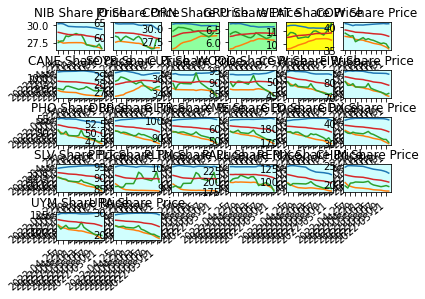

In [10]:
pd.set_option('display.max_columns', 1000000)
pd.set_option('display.max_rows', 1000000)

plt.rcParams.update({'figure.max_open_warning': 0})

rows = 5
cols = 6

def Bolinger_Bands(stock_price, window_size, num_of_std):

    rolling_mean = stock_price.rolling(window=window_size).mean()
    rolling_std  = stock_price.rolling(window=window_size).std()
    upper_band = rolling_mean + (rolling_std*num_of_std)
    lower_band = rolling_mean - (rolling_std*num_of_std)

    return rolling_mean, upper_band, lower_band

fig = plt.figure()
n=1

df = hist_for_corr

for tick in tickers_list:
    share_price = df[tick]
    #share_price = share_price.ffill()

    #print(share_price)

    rolling_mean, upper_band, lower_band = Bolinger_Bands(share_price, 20, 2)

    rolling_mean = rolling_mean.dropna()
    upper_band = upper_band.dropna()
    lower_band = lower_band.dropna()

    #print(rolling_mean)
    #print(upper_band)
    #rolling_mean2, upper_band2, lower_band2 = Bolinger_Bands(share_price, 20, 1.75)

    #sell_price = round(upper_band[-1], 4)

    #buy_price = round(rolling_mean[-1], 4)

    #current_price = round(share_price[-1], 4)

    sell_price = upper_band.iat[-1]

    buy_price = rolling_mean.iat[-1]

    current_price = share_price.iat[-1]

    print("$" + str(sell_price))

    #print("Sell @$" + str(sell_price) + " Buy back @$" + str(buy_price) +
    #     "! \nCurrent Price @$" + str(current_price))

    if current_price > buy_price and current_price < sell_price:
        #https://matplotlib.org/3.1.1/tutorials/colors/colors.html XKCD COLORS
        plot = fig.add_subplot(rows, cols, n).patch.set_facecolor('xkcd:mint green')
        plt.title(str(tick) + ' Share Price')
        plt.plot(upper_band[-14:])
        plt.plot(lower_band[-14:])
        #plt.plot(upper_band2[-14:])
        #plt.plot(lower_band2[-14:])
        plt.plot(share_price[-14:])
        plt.plot(rolling_mean[-14:])
        #plt.xlabel('Day')
        #plt.ylabel(str(tick) + ' Share Price')
        plt.rcParams["date.autoformatter.day"] = "%Y-%m-%d"
        plt.setp(plt.xticks()[1], rotation=40, ha='right')

    elif current_price > sell_price:
        plot = fig.add_subplot(rows, cols, n).patch.set_facecolor('xkcd:yellow')
        plt.title(str(tick) + ' Share Price')
        plt.plot(upper_band[-14:])
        plt.plot(lower_band[-14:])
        #plt.plot(upper_band2[-14:])
        #plt.plot(lower_band2[-14:])
        plt.plot(share_price[-14:])
        plt.plot(rolling_mean[-14:])
        #plt.xlabel('Day')
        #plt.ylabel(str(tick) + ' Share Price')
        plt.rcParams["date.autoformatter.day"] = "%Y-%m-%d"
        plt.setp(plt.xticks()[1], rotation=40, ha='right')

    elif current_price < buy_price:
        plot = fig.add_subplot(rows, cols, n).patch.set_facecolor('xkcd:pale blue')
        plt.title(str(tick) + ' Share Price')
        plt.plot(upper_band[-14:])
        plt.plot(lower_band[-14:])
        #plt.plot(upper_band2[-14:])
       # plt.plot(lower_band2[-14:])
        plt.plot(share_price[-14:])
        plt.plot(rolling_mean[-14:])
        #plt.xlabel('Day')
        #plt.ylabel(str(tick) + ' Share Price')
        plt.rcParams["date.autoformatter.day"] = "%Y-%m-%d"
        plt.setp(plt.xticks()[1], rotation=40, ha='right')

    n = n+1

fig.subplots_adjust(hspace=.7, wspace=.2)
plt.show()